<a href="https://colab.research.google.com/github/Stefanie04/MindMate/blob/main/Notebook_Stefanie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start ▶

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
#from google.colab import drive
#drive.mount('/content/drive')

import json

import io
import re
import random
import string
import tqdm
import pickle

import tensorflow as tf
from tensorflow.keras import layers

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sdonthi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
with open('Dataset/intents-rev2.json', 'r') as f:
    json_string = f.read()

# Preperation of the dataset 🚧

In [3]:
json_dict = json.loads(json_string)
intents = json_dict['intents']

In [5]:
tags = []
patterns = []
responses = {}
for intents in json_dict['intents']:
    responses[intents['tag']]=intents['responses']
    for lines in intents['patterns']:
      patterns.append(lines)
      tags.append(intents['tag'])
json_df = pd.DataFrame({'tags':tags, 'patterns':patterns})

# Pre-Processing 🏗

## Lowercases / removing punctuation

In [6]:
pre_df = json_df.apply(lambda x: x.astype(str).str.lower())

import string
pre_df = pre_df.apply(lambda x: x.astype(str).str.replace('[{}]'.format(string.punctuation),''))

C:\Users\sdonthi\AppData\Local\Temp/ipykernel_18300/1545242841.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  pre_df = pre_df.apply(lambda x: x.astype(str).str.replace('[{}]'.format(string.punctuation),''))


## Tokenization

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Create a Tokenizer object
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(pre_df['patterns'])
tokenized_text = tokenizer.texts_to_sequences(pre_df['patterns'])

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(tokenized_text)

from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
encoder = LabelEncoder()
y_train = encoder.fit_transform(pre_df['tags'])

#exporting the departure encoder
output = open('encoder.pkl', 'wb')
pickle.dump(encoder, output)
output.close()

In [8]:
pre_df.to_pickle('pre_df.pkl')

In [9]:
# Creating the word list
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 443 unique tokens.


In [10]:
print(x_train.shape)
print(y_train.shape)

(330, 21)
(330,)


In [11]:
output_length = encoder.classes_.shape[0]
print('Output length: ', output_length)

Output length:  166


# Model 🕸

In [12]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Flatten, Dense, Dropout

In [13]:
input_size = x_train.shape[1]
output_size = encoder.classes_.shape[0]

In [15]:
print("input_size=" + str(input_size) + ",output_size="+str(output_size))

input_size=21,output_size=166


In [16]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, 16, input_shape=(input_size,)))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(output_length, activation='sigmoid'))

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
11/11 [==============================] - 2s 11ms/step - loss: 5.1034 - accuracy: 0.0152
Epoch 2/200
11/11 [==============================] - 0s 10ms/step - loss: 5.0178 - accuracy: 0.0212
Epoch 3/200
11/11 [==============================] - 0s 10ms/step - loss: 4.8282 - accuracy: 0.0273
Epoch 4/200
11/11 [==============================] - 0s 10ms/step - loss: 4.7731 - accuracy: 0.0303
Epoch 5/200
11/11 [==============================] - 0s 10ms/step - loss: 4.7315 - accuracy: 0.0212
Epoch 6/200
11/11 [==============================] - 0s 10ms/step - loss: 4.7000 - accuracy: 0.0364
Epoch 7/200
11/11 [==============================] - 0s 11ms/step - loss: 4.6397 - accuracy: 0.0394
Epoch 8/200
11/11 [==============================] - 0s 11ms/step - loss: 4.5831 - accuracy: 0.0424
Epoch 9/200
11/11 [==============================] - 0s 12ms/step - loss: 4.5070 - accuracy: 0.0333
Epoch 10/200
11/11 [==============================] - 0s 11ms/step - loss: 4.4418 - accuracy: 0.0394

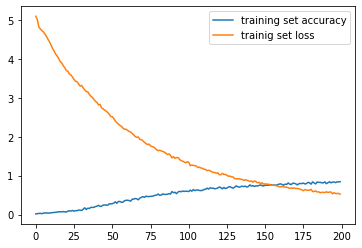

In [19]:
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='trainig set loss')
plt.legend()

In [21]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


#Chatbot 🤖

In [20]:
while True:
  conversation = []
  user_input = input('User: ')
  if user_input == 'bye':
    print('Goodbye and take care.')
    break

  # converting lowercase / removing punctuation 
  user_input = user_input.lower()
  user_input = re.sub(r'[^\w\s]', '', user_input)
  conversation.append(user_input)

  # tokenizer / padding
  user_input = tokenizer.texts_to_sequences(conversation)
  user_input = np.array(user_input).reshape(-1)
  user_input = pad_sequences([user_input], input_size)

  # output
  output = model.predict(user_input)
  output = output.argmax()

  # prediction
  response = encoder.inverse_transform([output])[0]
  print('response=' + response)
  if response in responses:
    print('Pocket Therapist: ', random.choice(responses[response]))
  else:
    print('Sorry, I do not understand. Can you please rephrase?')
  if response == 'goodbye':
    break

1/1 [==============================] - 0s 431ms/step
response=greeting
Pocket Therapist:  Great to see you. How do you feel currently?
1/1 [==============================] - 0s 15ms/step
response=about
Pocket Therapist:  You can call me MindMate.
1/1 [==============================] - 0s 16ms/step
response=about
Pocket Therapist:  I'm MindMate. I am a conversational agent designed to mimic a therapist. So how are you feeling today?
1/1 [==============================] - 0s 12ms/step
response=casual
Pocket Therapist:  Tell me more
1/1 [==============================] - 0s 15ms/step
response=casual
Pocket Therapist:  Come elucidate your thoughts
1/1 [==============================] - 0s 14ms/step
response=casual
Pocket Therapist:  How were you feeling last week?
1/1 [==============================] - 0s 13ms/step
response=casual
Pocket Therapist:  Tell me more
1/1 [==============================] - 0s 13ms/step
response=casual
Pocket Therapist:  I'm listening. Please go on.


KeyboardInterrupt: Interrupted by user

In [ ]:
model.save('mindmate_model.h5')

In [22]:
import os
from tensorflow import keras
# loading
#my_dir = os.path.dirname(__file__)
tokenizer1 = None
#model_path = os.path.join(my_dir, 'mindmate_model.h5')
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer1 = pickle.load(handle)

#model_path = os.path.join(my_dir, 'mindmate_model.h5')
pkl_file = open('encoder.pkl', 'rb')
le = pickle.load(pkl_file) 
pkl_file.close()

#model_path = os.path.join(my_dir, 'mindmate_model.h5')
model = keras.models.load_model('mindmate_model.h5')

In [23]:
while True:
  conversation = []
  input_size=21
  output_size=166
  user_input = input('User: ')
  if user_input == 'bye':
    print('Goodbye and take care.')
    break

  # converting lowercase / removing punctuation 
  user_input = user_input.lower()
  user_input = re.sub(r'[^\w\s]', '', user_input)
  conversation.append(user_input)

  # tokenizer / padding
  user_input = tokenizer1.texts_to_sequences(conversation)
  user_input = np.array(user_input).reshape(-1)
  user_input = pad_sequences([user_input], input_size)

  # output
  output = model.predict(user_input)
  output = output.argmax()

  # prediction
  response = le.inverse_transform([output])[0]
  print('response=' + response)
  if response in responses:
    print('Pocket Therapist: ', random.choice(responses[response]))
  else:
    print('Sorry, I do not understand. Can you please rephrase?')
  if response == 'goodbye':
    break

1/1 [==============================] - 0s 421ms/step
response=greeting
Pocket Therapist:  Hello there. Glad to see you're back. What's going on in your world right now?
1/1 [==============================] - 0s 15ms/step
response=greeting
Pocket Therapist:  Hello there. Tell me how are you feeling today?
1/1 [==============================] - 0s 16ms/step
response=about
Pocket Therapist:  I'm MindMate, your Personal Therapeutic AI Assistant. How are you feeling today
Goodbye and take care.
